In [1]:
using BenchmarkTools
using DifferentialEquations
using Plots

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1278
┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1278


In [2]:
# algunas funciones auxiliares

@inline function mysign_zero(a)
    return (1.0.*(a .> 0.0) + (-1.0).* (a .< 0.0))
end

@inline function minmod(a, b, c)
    sgnbc = (mysign_zero(b)+mysign_zero(c)) #this is 2 if both are positive, -2 if both are negative, 0 otherwise
    sgnac = (mysign_zero(a)+mysign_zero(c)) #this is 2 if both are positive, -2 if both are negative, 0 otherwise
    
    return 0.25*sgnbc*abs(sgnac)*min(abs(a), abs(b),abs(c))
end

@inline function minmod(a, b, c, θ)
   #be careful here, in the papers θ is usually multiplying a and c
    return minmod(a, θ*b, θ*c)
end

minmod (generic function with 2 methods)

In [3]:
#método de Kurganov-Tadmor

function KT!(dfields, fields, par, t)
    #The parameters are h, θ, auxiliary functions and auxiliary vectors
    
    eqpars, h::Float64, θ::Float64, Fx!, MaxSpeed, N::Int64, N_FIELDS::Int32, Dm, D, Dp, u_mm, u_mp, u_pm, u_pp, F_mm, F_mp, F_pm, F_pp, H_m, H_p = par
    
    
    for idx in 1:N
        idxll = mod(((idx-2) - 1),N) + 1
        idxl = mod(((idx-1) - 1),N) + 1
        idxr = mod(((idx+1) - 1),N) + 1
        idxrr = mod(((idx+2) - 1),N) + 1
        
        fll = @view fields[idxll,:]
        fl = @view fields[idxl,:]
        f = @view fields[idx,:]
        fr = @view fields[idxr,:]
        frr = @view fields[idxrr,:]
        
        @. Dm = minmod(0.5 *(f - fll), f-fl, fl-fll, θ) # * h
        @. D = minmod(0.5 *(fr - fl), fr-f, f-fl, θ) # * h
        @. Dp = minmod(0.5*(frr-f), frr-fr, fr-f, θ) # * h
        
        @. u_mm = fl + 0.5*Dm  #/h
        @. u_mp = f - 0.5*D #/h
        @. u_pm = f + 0.5*D #/h
        @. u_pp = fr - 0.5*Dp #/h
        
        Fx!(F_mm, u_mm, eqpars)
        Fx!(F_mp, u_mp, eqpars)
        Fx!(F_pm, u_pm, eqpars)
        Fx!(F_pp, u_pp, eqpars)
        
        
        a_m::Float64 = max(MaxSpeed(umm, eqpars), MaxSpeed(ump, eqpars))       
        a_p::Float64 = max(MaxSpeed(upm, eqpars), MaxSpeed(upp, eqpars))        

        
        @. H_m = 0.5 * (F_mp + F_mm) - 0.5 * a_m * (u_mp - u_mm)
        @. H_p = 0.5 * (F_pp + F_pm) - 0.5 * a_p * (u_pp - u_pm)
        
        @. dfields[idx, :] = -h*(H_p - H_m)
    end
    
end


KT! (generic function with 1 method)

In [4]:
#Algunas ecuaciones a evolucionar

function advection!(F, U, c)
    @. F = c*U
end

function advectionspeed(U, c)
    return abs(c)
end


function burgers!(F, U, Fpars::Bool=false)
    @. F = 0.5*U*U
end


function burgersspeed(U::Array{Float64,1}, c::Bool=false)
    return maximum(abs, U)  #no encuentro forma de escribir esto sin que aloque memoria...
end


function Euler1D!(Flux::Array{Float64,1}, U::Array{Float64,1}, γ::Float64)
    ρ::Float64 = U[1]    #density
    Sx::Float64 = U[2]   #momentum
    E::Float64 = U[3]    #energy
    v::Float64 = Sx/ρ  #fluid velocity
    p::Float64 = (γ-1.0)*(E - 0.5*ρ*v^2)
    
    Flux[1] = Sx
    Flux[2] = ρ*v^2 + p
    Flux[3] = v*(E+p)
    
    return Flux    
end

function SpeedEuler1D(U::Array{Float64,1}, γ::Float64)
    ρ = U[1]    #density
    Sx = U[2]   #momentum
    E = U[3]    #energy
    v::Float64 = Sx/ρ  #fluid velocity
    p::Float64 = (γ-1.0)*(E - 0.5*ρ*v^2)
    
    return sqrt(γ*p/ρ) + abs(v)    
end


SpeedEuler1D (generic function with 1 method)

In [5]:
N = 200
N_FIELDS = 1

start = 0.0
stop = 2.0*pi
x = range(start, stop =stop, length = N+1)[1:end-1] #so it doesn't include the last point
dx = Float64(x.step)  #no estoy seguro de si hay una forma más elegante de conseguir este valor
h = 1.0/dx
#we initialize the data
u = Array{Float64}(undef, N, N_FIELDS)
du = copy(u)
@. u[:,1] = 0.5 + sin(x)

#we initialize empty arrays
D = Array{Float64}(undef, N_FIELDS)
Dm = copy(D)
Dp = copy(D)
umm = copy(D)
ump = copy(D)
upm = copy(D)
upp = copy(D)
Fmm = copy(D)
Fmp = copy(D)
Fpm = copy(D)
Fpp = copy(D)
Hm = copy(D)
Hp = copy(D)


#we define our integration interval and dt
T = 2.0
tspan = (0.0, T)

#CFL = dt/dx
CFL = 0.1
dt = dx * CFL

θ = 2.0

eqpars = false

par = (eqpars, h, θ, burgers!, burgersspeed, N, N_FIELDS, Dm, D, Dp, umm, ump, upm, upp, Fmm, Fmp, Fpm, Fpp, Hm, Hp)

(false, 31.830988618379067, 2.0, burgers!, burgersspeed, 200, 1, [5.0e-324], [5.0e-324], [5.0e-324], [5.0e-324], [5.0e-324], [5.0e-324], [5.0e-324], [5.0e-324], [5.0e-324], [5.0e-324], [5.0e-324], [5.0e-324], [5.0e-324])

In [6]:
prob = ODEProblem(KT!,u,tspan,par);
sol = solve(prob,SSPRK33(),dt=dt, saveat = T/100); # This is a TVD method
#@benchmark sol = solve(prob,SSPRK33(),dt=dt, saveat = T/100) # This is a TVD method


In [7]:
using Printf

┌ Info: Saved animation to 
│   fn = /Users/reula/Docencia/PDE2020/pde/Tarea_4/burgers_sin.gif
└ @ Plots /Users/reula/.julia/packages/Plots/hyS17/src/animation.jl:104


Plots.AnimatedGif("/Users/reula/Docencia/PDE2020/pde/Tarea_4/burgers_sin.gif")
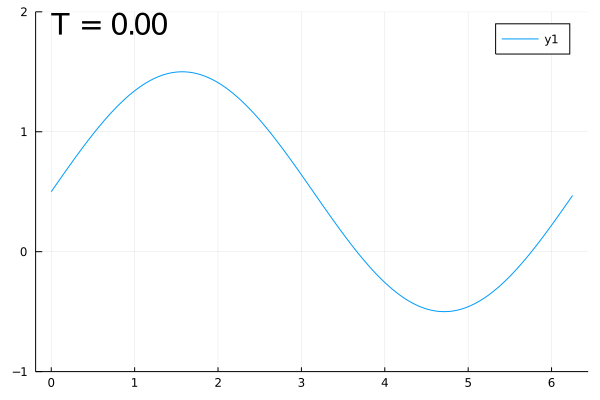

In [8]:
anim = @animate for t in sol.t
    plt = plot(x, sol(t), ylims = (-1.0,2.0))
    annotate!(plt, 0.0, 1.9, text("T = $(@sprintf("%.2f", t))", :black, :left, 20))
end
gif(anim, "burgers_sin.gif", fps = 30)

## Euler equations

In [9]:
#inidat functions
function sodinidat(xarray, u, γ)
    #sod shock-tube
    #ρ_l = 1.0, p_l = 1.0, u_l = 0.0;
    #ρ_r = 0.125, p_r = 0.1, u_r = 0.0; 
    
    outside = @. abs(x) > 1.0
    inside = @. !outside
    
    ρ = @view u[:,1]
    Sx = @view u[:,2]
    E = @view u[:,3]
    
    @. ρ[inside] = 1.0
    @. Sx[inside] = 0.0
    @. E[inside] = 1.0/(γ-1.0)   #warning, I assume the momentum is zero
    
    @. ρ[outside] = 0.125
    @. Sx[outside] = 0.0
    @. E[outside] = 0.1/(γ-1.0)   #warning, I assume the momentum is zero
        
end

sodinidat (generic function with 1 method)

In [10]:

N = 2000
N_FIELDS = 3

start = -2.0
stop = 2.0
x = range(start, stop =stop, length = N+1)[1:end-1] #so it doesn't include the last point
dx = Float64(x.step)  #no estoy seguro de si hay una forma más elegante de conseguir este valor
h = 1.0/dx
#we initialize the data
u = Array{Float64}(undef, N, N_FIELDS)
du = copy(u)

γ = 1.4
sodinidat(x, u, γ)


#we initialize empty arrays
D = Array{Float64}(undef, N_FIELDS)
Dm = copy(D)
Dp = copy(D)
umm = copy(D)
ump = copy(D)
upm = copy(D)
upp = copy(D)
Fmm = copy(D)
Fmp = copy(D)
Fpm = copy(D)
Fpp = copy(D)
Hm = copy(D)
Hp = copy(D)

#we define our integration interval and dt
T = 2.0
tspan = (0.0, T)

#CFL = dt/dx
CFL = 0.1
dt = dx * CFL

θ = 1.0

eqpars = γ

par = (eqpars, h, θ, Euler1D!, SpeedEuler1D, N, N_FIELDS, Dm, D, Dp, umm, ump, upm, upp, Fmm, Fmp, Fpm, Fpp, Hm, Hp);

In [11]:
prob = ODEProblem(KT!,u,tspan,par);
sol = solve(prob,SSPRK33(),dt=dt, saveat = T/100); # This is a TVD method

┌ Info: Saved animation to 
│   fn = /Users/reula/Docencia/PDE2020/pde/Tarea_4/euler.gif
└ @ Plots /Users/reula/.julia/packages/Plots/hyS17/src/animation.jl:104


Plots.AnimatedGif("/Users/reula/Docencia/PDE2020/pde/Tarea_4/euler.gif")
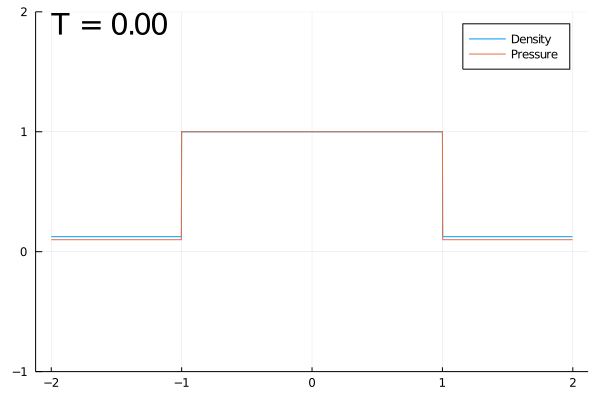

In [12]:
pressure = zeros(N)
anim = @animate for t in sol.t
    fields = sol(t)
    ρ = @view fields[:,1]   #density
    Sx = @view fields[:,2]  #moment
    E = @view fields[:,3]   #density
    @. pressure = (γ-1.0)*(E - 0.5*Sx^2/ρ)
    plt = plot(x, ρ, ylims = (-1.0,2.0), label = "Density")
    plot!(plt, x, pressure, ylims = (-1.0,2.0), label = "Pressure")
    annotate!(plt, -2.0, 1.9, text("T = $(@sprintf("%.2f", t))", :black, :left, 20))
    end
gif(anim, "euler.gif", fps = 30)

# Convergencia

In [13]:
sollist = []
dxlist = []

for N in [40,80,160]
    N_FIELDS = 1

    start = 0.0
    stop = 2.0*pi
    x = range(start, stop =stop, length = N+1)[1:end-1] #so it doesn't include the last point
    dx = Float64(x.step)  #no estoy seguro de si hay una forma más elegante de conseguir este valor
    push!(dxlist, dx)
    h = 1.0/dx
    #we initialize the data
    u = Array{Float64}(undef, N, N_FIELDS)
    du = copy(u)
    @. u[:,1] = 0.5 + sin(x)

    #we initialize empty arrays
    D = Array{Float64}(undef, N_FIELDS)
    Dm = copy(D)
    Dp = copy(D)
    umm = copy(D)
    ump = copy(D)
    upm = copy(D)
    upp = copy(D)
    Fmm = copy(D)
    Fmp = copy(D)
    Fpm = copy(D)
    Fpp = copy(D)
    Hm = copy(D)
    Hp = copy(D)


    #we define our integration interval and dt
    T = 2.0
    tspan = (0.0, T)

    #CFL = dt/dx
    CFL = 0.01
    dt = dx * CFL

    θ = 2.0

    eqpars = false

    par = (eqpars, h, θ, burgers!, burgersspeed, N, N_FIELDS, Dm, D, Dp, umm, ump, upm, upp, Fmm, Fmp, Fpm, Fpp, Hm, Hp)

    prob = ODEProblem(KT!,u,tspan,par);
    sol = solve(prob,SSPRK33(),dt=dt, saveat = dt*floor(T/100/dt)); # This is a TVD method
    push!(sollist, sol)
    #@benchmark sol = solve(prob,SSPRK33(),dt=dt, saveat = T/100) # This is a TVD method
end

In [14]:
function Lipprime(u, dx)
    pr = zeros(size(u)[1])
    for i in 2:size(u)[1]
        pr[i] = pr[i-1] + (u[i]+u[i-1])*dx
    end
    return sum(abs.(pr))*dx
end
    

Lipprime (generic function with 1 method)

In [15]:
Qlist = []
for t in sollist[1].t
    n1 = Lipprime(sollist[1](t)[:,1]-sollist[2](t)[1:2:end,1], dxlist[1])
    n2 = Lipprime(sollist[2](t)[:,1]-sollist[3](t)[1:2:end,1], dxlist[2])
    push!(Qlist, n1/n2)
end

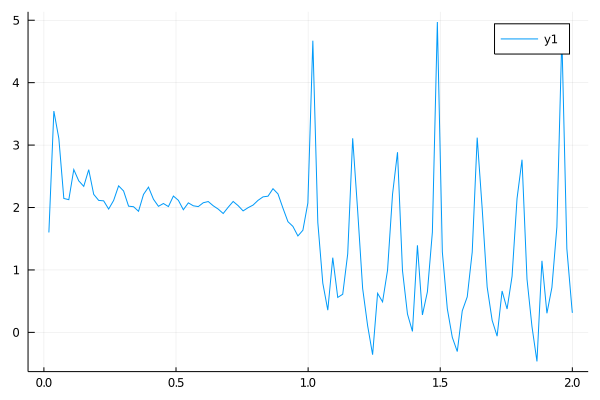

In [16]:
plot(sollist[1].t, log2.(Qlist))